# Transformer Text Classification (from scratch, PyTorch)

This notebook trains a small Transformer encoder (no HuggingFace) on the full IMDB movie review dataset (25k train / 25k test) for binary sentiment classification.

**Outputs**
- `training_curves.png`
- `transformer_text_classifier.pt`


In [54]:
# Cell 1 - Imports + setup
import re
import math
import time
from collections import Counter
from typing import List, Dict, Tuple

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

torch.manual_seed(0)
np.random.seed(0)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)


Device: mps


In [56]:
import sys
print(sys.executable)

/Users/Chris/miniconda3/envs/tensorflow/bin/python


In [58]:
# Load FULL IMDB dataset (25k train / 25k test)
from datasets import load_dataset
from sklearn.model_selection import train_test_split

dataset = load_dataset('imdb')

train_texts_all = dataset['train']['text']
train_labels_all = dataset['train']['label']

test_texts = dataset['test']['text']
test_labels = dataset['test']['label']

# Create a validation split from training set
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts_all, train_labels_all,
    test_size=0.10,
    random_state=0,
    stratify=train_labels_all
)

print('Train:', len(train_texts), 'Val:', len(val_texts), 'Test:', len(test_texts))


Train: 22500 Val: 2500 Test: 25000


In [60]:
!{sys.executable} -m pip install datasets


## 1) Tiny dataset + tokenizer + vocab
We’ll use a small dataset so the notebook always runs.
You can swap in a real dataset later (AG News / IMDB) once everything works.


In [63]:
# Hyperparameters for full IMDB
max_len = 256        # keep modest to avoid OOM on laptops
max_vocab = 30000    # cap vocabulary size

# Training hyperparameters
batch_size = 64
epochs = 6
lr = 3e-4


In [65]:
# Cell 2 - Tokenization, vocab building, encoding
import re
from collections import Counter

def tokenize(text):
    return re.findall(r"\b\w+\b", text.lower())

def build_vocab(texts, max_vocab=2000, min_freq=1):
    from collections import Counter

    counter = Counter()
    for t in texts:
        counter.update(t.split())

    vocab = {
        "<pad>": 0,
        "<unk>": 1,
    }

    for word, freq in counter.most_common():
        if freq < min_freq:
            continue
        if len(vocab) >= max_vocab:
            break
        if word not in vocab:
            vocab[word] = len(vocab)

    return vocab

PAD = "<pad>"
UNK = "<unk>"

def encode(text, vocab, max_len=32):
    tokens = tokenize(text)
    unk_id = vocab[UNK]
    pad_id = vocab[PAD]

    ids = [vocab.get(tok, unk_id) for tok in tokens]
    ids = ids[:max_len]
    ids += [pad_id] * (max_len - len(ids))
    return ids

In [67]:
PAD = "<pad>"
UNK = "<unk>"

In [69]:
# Cell 1 - Load IMDB dataset
from datasets import load_dataset

dataset = load_dataset("imdb")

texts = dataset["train"]["text"]
labels = dataset["train"]["label"]

print("Number of samples:", len(texts))
print("Example text:\n", texts[0][:300])
print("Label example:", labels[0])

Number of samples: 25000
Example text:
 I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really h
Label example: 0


In [71]:
# Cell 3 - Build vocab + encode dataset
max_len = 32
vocab = build_vocab(texts, max_vocab=2000, min_freq=1)
print("Vocab size:", len(vocab))

X = np.array([encode(t, vocab, max_len=max_len) for t in texts], dtype=np.int64)
y = np.array(labels, dtype=np.int64)
print("X shape:", X.shape, "y shape:", y.shape)

# Train/val split
idx = np.arange(len(y))
np.random.shuffle(idx)
split = int(0.75 * len(y))
tr, va = idx[:split], idx[split:]

X_train, y_train = X[tr], y[tr]
X_val, y_val = X[va], y[va]
print("Train:", X_train.shape, "Val:", X_val.shape)


Vocab size: 2000
X shape: (25000, 32) y shape: (25000,)
Train: (18750, 32) Val: (6250, 32)


## 2) Model: Transformer encoder + pooling + classifier


In [74]:
# Cell 4 - Model definition
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        T = x.size(1)
        return x + self.pe[:, :T, :]


class TransformerTextClassifier(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        n_classes: int,
        d_model: int = 128,
        n_heads: int = 4,
        n_layers: int = 2,
        dim_ff: int = 256,
        max_len: int = 256,
        dropout: float = 0.1,
        pad_id: int = 0,
    ):
        super().__init__()
        self.pad_id = pad_id

        self.token_emb = nn.Embedding(vocab_size, d_model, padding_idx=pad_id)
        self.pos_enc = PositionalEncoding(d_model, max_len=max_len)
        self.drop = nn.Dropout(dropout)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=dim_ff,
            dropout=dropout,
            batch_first=True,
            activation="gelu",
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)

        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, n_classes),
        )

    def forward(self, input_ids: torch.Tensor) -> torch.Tensor:
        # input_ids: (B, T)
        pad_mask = (input_ids == self.pad_id)  # True where PAD

        x = self.token_emb(input_ids)  # (B, T, d_model)
        x = self.pos_enc(x)
        x = self.drop(x)

        x = self.encoder(x, src_key_padding_mask=pad_mask)  # (B, T, d_model)

        # Mean pooling over non-pad tokens
        not_pad = (~pad_mask).unsqueeze(-1).float()  # (B, T, 1)
        pooled = (x * not_pad).sum(dim=1) / not_pad.sum(dim=1).clamp(min=1.0)

        return self.classifier(pooled)


model = TransformerTextClassifier(
    vocab_size=len(vocab),
    n_classes=len(np.unique(y)),
    d_model=128,
    n_heads=4,
    n_layers=2,
    dim_ff=256,
    max_len=max_len,
    dropout=0.1,
    pad_id=vocab[PAD],
).to(device)

print(model)


TransformerTextClassifier(
  (token_emb): Embedding(2000, 128, padding_idx=0)
  (pos_enc): PositionalEncoding()
  (drop): Dropout(p=0.1, inplace=False)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Sequential(
    (0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=128, out_features=2, bia

/Users/Chris/miniconda3/envs/tensorflow/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


## 3) DataLoader


In [77]:
# Cell 5 - Dataset/Dataloader
class TextDataset(Dataset):
    def __init__(self, X_ids: np.ndarray, y: np.ndarray):
        self.X_ids = torch.from_numpy(np.asarray(X_ids, dtype=np.int64))
        self.y = torch.from_numpy(np.asarray(y, dtype=np.int64))

    def __len__(self):
        return self.X_ids.shape[0]

    def __getitem__(self, idx):
        return self.X_ids[idx], self.y[idx]


train_ds = TextDataset(X_train, y_train)
val_ds = TextDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False)

print("Batches per epoch (train):", len(train_loader))


Batches per epoch (train): 4688


## 4) Train loop (with timing)


In [82]:
# Cell 6 - Training with Early Stopping
def batch_accuracy(logits: torch.Tensor, yb: torch.Tensor) -> float:
    pred = logits.argmax(dim=1)
    return (pred == yb).float().mean().item()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

epochs = 30
train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_val = -1.0

# ---- early stopping settings ----
patience = 5          # stop if no improvement for 5 epochs
min_delta = 0.002     # require at least this improvement in val_acc
wait = 0              # how many epochs since last improvement

t0 = time.time()

for epoch in range(1, epochs + 1):
    ep_start = time.time()

    # ---- train ----
    model.train()
    loss_sum, acc_sum, n = 0.0, 0.0, 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        bs = yb.size(0)
        loss_sum += loss.item() * bs
        acc_sum += batch_accuracy(logits, yb) * bs
        n += bs

    tr_loss = loss_sum / n
    tr_acc = acc_sum / n

    # ---- val ----
    model.eval()
    loss_sum, acc_sum, n = 0.0, 0.0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)

            bs = yb.size(0)
            loss_sum += loss.item() * bs
            acc_sum += batch_accuracy(logits, yb) * bs
            n += bs

    va_loss = loss_sum / n
    va_acc = acc_sum / n

    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    train_accs.append(tr_acc)
    val_accs.append(va_acc)

    ep_time = time.time() - ep_start
    print(
        f"Epoch {epoch:02d} | train_loss={tr_loss:.3f} acc={tr_acc:.3f} | "
        f"val_loss={va_loss:.3f} acc={va_acc:.3f} | {ep_time:.2f}s"
    )

    # ---- early stopping logic (based on val accuracy) ----
    if va_acc > best_val + min_delta:
        best_val = va_acc
        wait = 0
        torch.save(model.state_dict(), "transformer_best.pt")
        print(f"  ↳ New best val_acc={best_val:.4f}. Saved transformer_best.pt")
    else:
        wait += 1
        print(f"  ↳ No improvement. patience {wait}/{patience}")
        if wait >= patience:
            print(f"Early stopping at epoch {epoch} (best val_acc={best_val:.4f})")
            break

total = time.time() - t0
print("Best val acc:", best_val)
print(f"Total training time: {total:.2f}s")

Epoch 01 | train_loss=0.235 acc=0.899 | val_loss=0.902 acc=0.681 | 41.67s
  ↳ New best val_acc=0.6806. Saved transformer_best.pt
Epoch 02 | train_loss=0.225 acc=0.905 | val_loss=0.968 acc=0.680 | 42.07s
  ↳ No improvement. patience 1/5
Epoch 03 | train_loss=0.217 acc=0.908 | val_loss=0.990 acc=0.680 | 41.85s
  ↳ No improvement. patience 2/5
Epoch 04 | train_loss=0.213 acc=0.912 | val_loss=1.040 acc=0.680 | 41.76s
  ↳ No improvement. patience 3/5
Epoch 05 | train_loss=0.210 acc=0.913 | val_loss=0.925 acc=0.678 | 41.90s
  ↳ No improvement. patience 4/5
Epoch 06 | train_loss=0.201 acc=0.918 | val_loss=1.044 acc=0.685 | 42.13s
  ↳ New best val_acc=0.6850. Saved transformer_best.pt
Epoch 07 | train_loss=0.196 acc=0.919 | val_loss=1.045 acc=0.681 | 42.28s
  ↳ No improvement. patience 1/5
Epoch 08 | train_loss=0.188 acc=0.925 | val_loss=1.035 acc=0.669 | 43.06s
  ↳ No improvement. patience 2/5
Epoch 09 | train_loss=0.183 acc=0.926 | val_loss=1.049 acc=0.672 | 42.58s
  ↳ No improvement. patien

## 5) Plot curves + save model


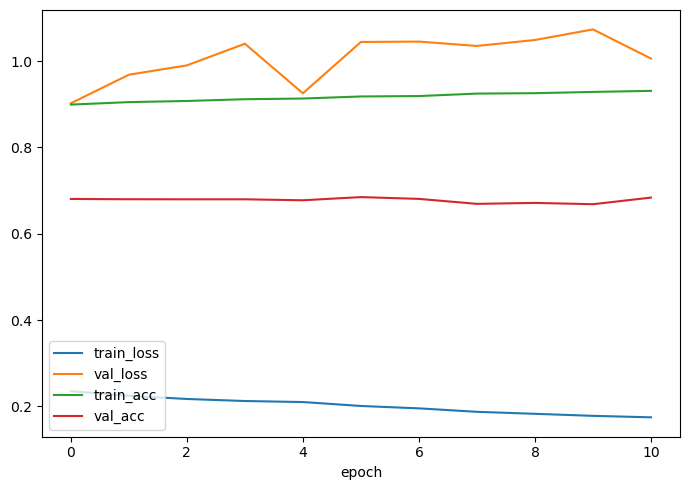

Saved: training_curves.png


In [85]:
# Cell 7 - Plot training curves
plt.figure(figsize=(7,5))
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.plot(train_accs, label="train_acc")
plt.plot(val_accs, label="val_acc")
plt.xlabel("epoch")
plt.legend()
plt.tight_layout()
plt.savefig("training_curves.png", dpi=200)
plt.show()

print("Saved: training_curves.png")


In [87]:
# Cell 8 - Save a portable checkpoint (weights + vocab + max_len)
ckpt = {
    "model_state": model.state_dict(),
    "vocab": vocab,
    "max_len": max_len,
}
torch.save(ckpt, "transformer_text_classifier.pt")
print("Saved: transformer_text_classifier.pt")


Saved: transformer_text_classifier.pt


## Quick prediction on a new sentence


In [90]:
# Cell 9 - Predict
id_to_label = {0: "negative", 1: "positive"}

def predict(text: str):
    model.eval()
    ids = np.array([encode(text, vocab, max_len=max_len)], dtype=np.int64)
    xb = torch.from_numpy(ids).to(device)
    with torch.no_grad():
        logits = model(xb)
        prob = torch.softmax(logits, dim=1).cpu().numpy()[0]
        pred = int(np.argmax(prob))
    return pred, prob

test_texts = [
    "I really loved this, it was fantastic",
    "This was boring and I hated it",
]

for t in test_texts:
    pred, prob = predict(t)
    print(f"{t!r} -> {id_to_label[pred]}  probs={prob}")


'I really loved this, it was fantastic' -> positive  probs=[0.00164806 0.99835193]
'This was boring and I hated it' -> negative  probs=[0.99821967 0.00178026]
